In [494]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as stats
from scipy.stats import linregress
import json
from pprint import pprint

#BITCOIN API: url setup
url = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
default = 'start=2020-01-01&end=2020-12-31'

# set start and end date variables
# NOTE: must stay within 2020 range, csv files (dow & gold) are limited to this range
start_date = '2020-01-01'
end_date = '2020-12-31'

# DOW: file to Load, read csv, dataframe
file_to_load = "data/dow.csv"
dow_data = pd.read_csv(file_to_load)
dow_data_df = pd.DataFrame(dow_data)

# GOLD: file to load, read csv, dataframe
file_to_load = "data/gold.csv"
gold_data = pd.read_csv(file_to_load)
gold_data_df = pd.DataFrame(gold_data)
gold_data_df.columns = gold_data_df.columns.tolist()[:1] + ['Close'] + gold_data_df.columns.tolist()[2:]

In [495]:
# BITCOIN: create query url for start and end date, request json
query_url = f'{url}start={start_date}&end={end_date}'
pprint(requests.get(query_url).json())

{'bpi': {'2020-01-01': 7188.4633,
         '2020-01-02': 6961.5683,
         '2020-01-03': 7346.58,
         '2020-01-04': 7355.855,
         '2020-01-05': 7356.3117,
         '2020-01-06': 7761.825,
         '2020-01-07': 8157.7617,
         '2020-01-08': 8042.8733,
         '2020-01-09': 7816.9233,
         '2020-01-10': 8189.265,
         '2020-01-11': 8016.4267,
         '2020-01-12': 8178.8833,
         '2020-01-13': 8105.4783,
         '2020-01-14': 8807.4267,
         '2020-01-15': 8808.4867,
         '2020-01-16': 8716.9133,
         '2020-01-17': 8890.25,
         '2020-01-18': 8901.17,
         '2020-01-19': 8698.5717,
         '2020-01-20': 8631.2883,
         '2020-01-21': 8727.6033,
         '2020-01-22': 8661.01,
         '2020-01-23': 8392.145,
         '2020-01-24': 8436.49,
         '2020-01-25': 8337.1017,
         '2020-01-26': 8602.7417,
         '2020-01-27': 8901.5067,
         '2020-01-28': 9393.2733,
         '2020-01-29': 9290.46,
         '2020-01-30': 9508.72

In [496]:
# BITCOIN: create response, create dataframe of date range results from API
response = requests.get(query_url).json()
my_dict = response['bpi']
test_df = pd.DataFrame(list(my_dict.items()),columns = ['close date','close price']) 

# test_df

In [497]:
# DOW: clean data (take out out-of-range data based on start_/end_date variables above)
# return only date and close price columns
dow_cleaned = dow_data_df.loc[(dow_data_df['Date'] >= start_date) & (dow_data_df['Date'] <= end_date)]
dow_cleaned = dow_cleaned[['Date','Close']]

# rename date column to prep for merge
dow_df = dow_cleaned.rename(columns={'Date':'close date'})

# dow_cleaned

In [498]:
# GOLD: clean data - convert to_datetime
gold_data_df['Date'] = pd.to_datetime(gold_data_df['Date'])

# clean data - take out out-of-range data based on start_/end_date variables above
# return only date and close price columns
gold_cleaned = gold_data_df.loc[(gold_data_df['Date'] >= start_date) & (gold_data_df['Date'] <= end_date)]
gold_cleaned = gold_cleaned.sort_values(by=['Date']).reset_index(drop=True)
gold_cleaned = gold_cleaned.iloc[:,0:2]

# rename date column to prep for merge
gold_df = gold_cleaned.rename(columns={'Date':'close date'})

# gold_df

In [499]:
# BITCOIN & 
merged = pd.merge(test_df, dow_df, on='close date', how='left')
merged['close date'] = pd.to_datetime(merged['close date'])

merged = pd.merge(merged, gold_df, on='close date', how='left', suffixes=('_dow','_gold'))
merged = merged.rename(columns={'close date':'Date','close price':'Bitcoin', 'Close_dow':'Dow', 'Close_gold':'Gold'})

# merged

In [500]:
#drop NaN values (aka weekends & holidays)
merged = merged.dropna()
merged

,Date,Bitcoin,Dow,Gold
1,2020-01-02,6961.5683,28868.800781,1528.1
2,2020-01-03,7346.5800,28634.880859,1549.2
5,2020-01-06,7761.8250,28703.380859,1568.8
6,2020-01-07,8157.7617,28583.679688,1574.3
7,2020-01-08,8042.8733,28745.089844,1560.2
...,...,...,...,...
358,2020-12-24,23729.6483,30199.869141,1883.2
362,2020-12-28,27041.8667,30403.970703,1880.4
363,2020-12-29,27353.9783,30335.669922,1882.9
364,2020-12-30,28886.0400,30409.560547,1893.4


In [501]:
#Settting variables for % change
pct_dow = merged['Dow'].pct_change()
pct_bitcoin = merged['Bitcoin'].pct_change()
pct_gold = merged['Gold'].pct_change()

#adding to DF
merged_wpct = merged
merged_wpct['% Chg Bitcoin'] = pct_bitcoin
merged_wpct['% Chg Dow'] = pct_dow
merged_wpct['% Chg Gold'] = pct_gold 
merged_wpct

,Date,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
1,2020-01-02,6961.5683,28868.800781,1528.1,NaN,NaN,NaN
2,2020-01-03,7346.5800,28634.880859,1549.2,0.055305,-0.008103,0.013808
5,2020-01-06,7761.8250,28703.380859,1568.8,0.056522,0.002392,0.012652
6,2020-01-07,8157.7617,28583.679688,1574.3,0.051011,-0.004170,0.003506
7,2020-01-08,8042.8733,28745.089844,1560.2,-0.014083,0.005647,-0.008956
...,...,...,...,...,...,...,...
358,2020-12-24,23729.6483,30199.869141,1883.2,0.021552,0.002325,0.002716
362,2020-12-28,27041.8667,30403.970703,1880.4,0.139581,0.006758,-0.001487
363,2020-12-29,27353.9783,30335.669922,1882.9,0.011542,-0.002246,0.001330
364,2020-12-30,28886.0400,30409.560547,1893.4,0.056009,0.002436,0.005577


In [502]:
merged_wpct.dropna(how='any', inplace=True)
merged_wpct

,Date,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
2,2020-01-03,7346.5800,28634.880859,1549.2,0.055305,-0.008103,0.013808
5,2020-01-06,7761.8250,28703.380859,1568.8,0.056522,0.002392,0.012652
6,2020-01-07,8157.7617,28583.679688,1574.3,0.051011,-0.004170,0.003506
7,2020-01-08,8042.8733,28745.089844,1560.2,-0.014083,0.005647,-0.008956
8,2020-01-09,7816.9233,28956.900391,1554.3,-0.028093,0.007369,-0.003782
...,...,...,...,...,...,...,...
358,2020-12-24,23729.6483,30199.869141,1883.2,0.021552,0.002325,0.002716
362,2020-12-28,27041.8667,30403.970703,1880.4,0.139581,0.006758,-0.001487
363,2020-12-29,27353.9783,30335.669922,1882.9,0.011542,-0.002246,0.001330
364,2020-12-30,28886.0400,30409.560547,1893.4,0.056009,0.002436,0.005577


In [503]:
# setting axes to variables
bitcoin_x = merged['Bitcoin']
dow_x = merged['Dow']
gold_x = merged['Gold']
all_y = merged['Date']

In [504]:
# set up colors
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

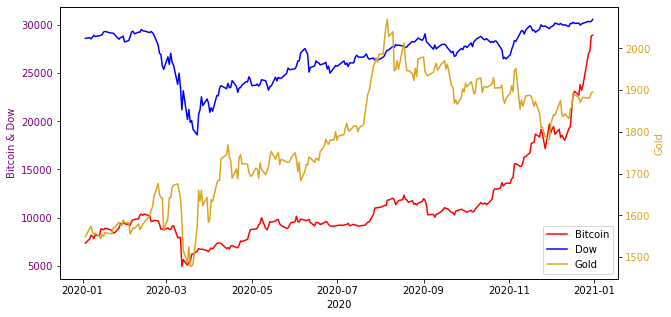

In [505]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()

# here's the link to the info on overlaying two axes: 
# https://matplotlib.org/gallery/api/two_scales.html

# link to combining all plots into one legend:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

# link to changing fig size
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

In [506]:
# setting axes to variables
bitcoin_pct_x = merged_wpct['% Chg Bitcoin']
dow_pct_x = merged_wpct['% Chg Dow']
gold_pct_x = merged_wpct['% Chg Gold']
all_y = merged_wpct['Date']

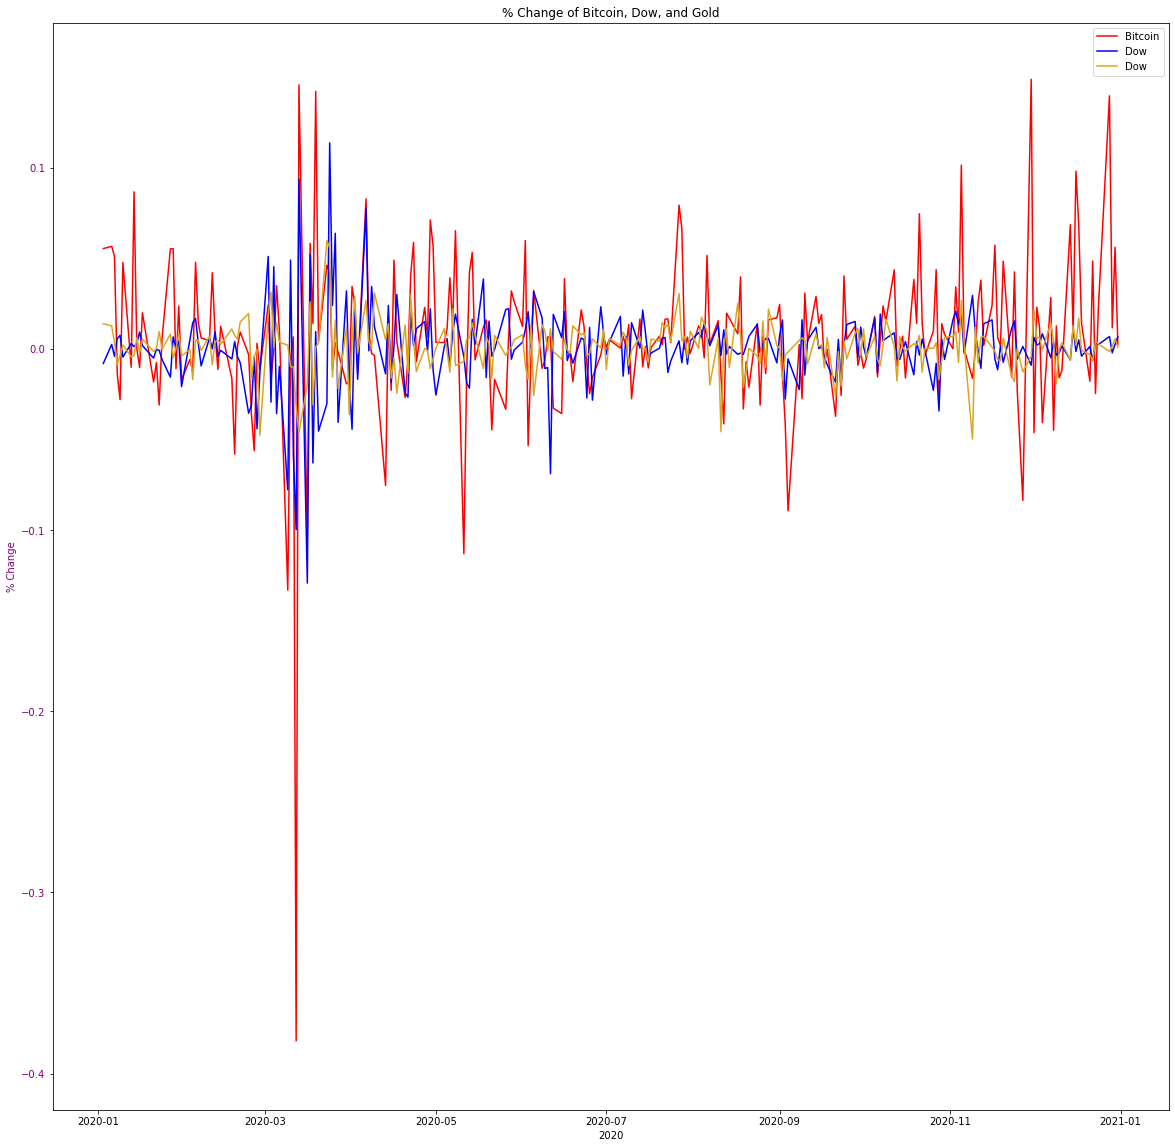

In [507]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_pct_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_pct_x, color=color_dow, label='Dow')
plot3 = ax1.plot(all_y, gold_pct_x, color=color_gold, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_title('% Change of Bitcoin, Dow, and Gold')
ax1.set_xlabel('2020')
ax1.set_ylabel('% Change', color=color_label)
ax1.plot()

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(20, 20, forward=True)
ax1.set_ylim(-0.42,0.18)
plt.show()

In [508]:
curr_list = ['Bitcoin', 'Dow', 'Gold', '% Chg Bitcoin', '% Chg Dow', '% Chg Gold']
all_list = [] 

for currency in curr_list:
    item = merged_wpct[currency].tolist()
    # add subset  
    all_list.append(item)

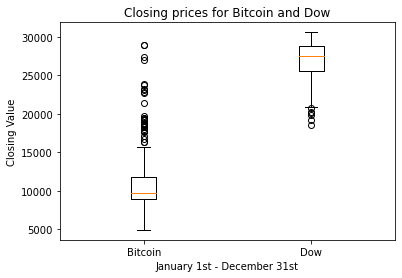

In [509]:
# BITCOIN & DOW boxplots
fig1, ax1 = plt.subplots()

ax1.set_title('Closing prices for Bitcoin and Dow')
ax1.set_ylabel('Closing Value')
ax1.boxplot(all_list[:2])
plt.xlabel('January 1st - December 31st')
plt.xticks([1,2], curr_list[:2])
plt.show()


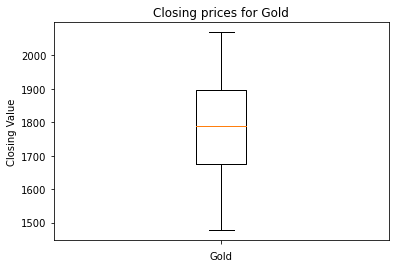

In [510]:
#GOLD Boxplot
fig1, ax1 = plt.subplots()

ax1.set_title('Closing prices for Gold')
ax1.set_ylabel('Closing Value')
ax1.boxplot(all_list[2])
plt.xlabel('Gold')
plt.xticks([1],'')
plt.show()

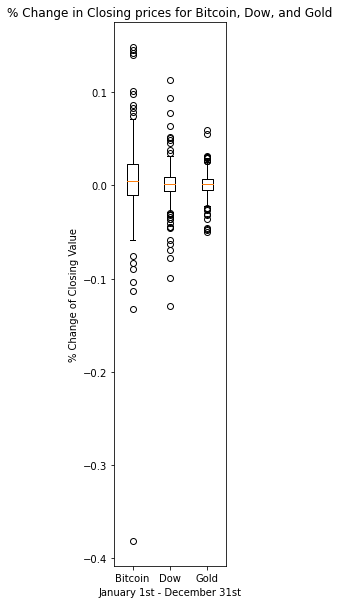

In [511]:
# # BITCOIN & DOW boxplots
fig1, ax1 = plt.subplots()

ax1.set_title('% Change in Closing prices for Bitcoin, Dow, and Gold')
ax1.set_ylabel('% Change of Closing Value')
ax1.boxplot(all_list[3:6])
plt.xlabel('January 1st - December 31st')
plt.xticks([1,2,3], ['Bitcoin', 'Dow', 'Gold'])
fig1.set_size_inches(2, 10, forward=True)
plt.show()

In [512]:
#ANOVA ALL
bit_group = merged_wpct['% Chg Bitcoin'].dropna()
dow_group = merged_wpct['% Chg Dow'].dropna()
gold_group = merged_wpct['% Chg Gold'].dropna()

stats.f_oneway(bit_group, dow_group, gold_group)
# group1

F_onewayResult(statistic=3.4084040528951722, pvalue=0.0336053961950678)

In [513]:
#ANOVA BITCOIN V DOW
stats.f_oneway(bit_group, dow_group)

F_onewayResult(statistic=3.924960404766065, pvalue=0.04811953130735786)

In [514]:
#ANOVA BITCOIN V GOLD
stats.f_oneway(bit_group, gold_group)

F_onewayResult(statistic=3.933434383922489, pvalue=0.04787962360888643)

In [515]:
#ANOVA DOW V GOLD
stats.f_oneway(dow_group, gold_group)

F_onewayResult(statistic=0.06903893879570347, pvalue=0.7928490552564835)

In [516]:
# create a summary statistics table
stats_table = merged_wpct.describe()

# find IQR * 1.5 
bit_bound = (stats_table.iloc[6,3] - stats_table.iloc[4,3]) * 1.5
dow_bound = (stats_table.iloc[6,4] - stats_table.iloc[4,4]) * 1.5
gold_bound = (stats_table.iloc[6,5] - stats_table.iloc[4,5]) * 1.5

# find lower bounds for outliers
bit_lowbound = stats_table.iloc[4,3] - bit_bound
dow_lowbound = stats_table.iloc[4,4] - dow_bound
gold_lowbound = stats_table.iloc[4,5] - gold_bound

# create the upper bounds for outliers
bit_upbound = stats_table.iloc[6,3] + bit_bound
dow_upbound = stats_table.iloc[6,4] + dow_bound
gold_upbound = stats_table.iloc[6,5] + gold_bound



# pull bitcoin lower outliers from df
bit_lowout = merged_wpct.loc[merged_wpct['% Chg Bitcoin'] < bit_lowbound]
bit_lowout = bit_lowout[['Date','% Chg Bitcoin']]

# pull dow lower outliers from df
dow_lowout = merged_wpct.loc[merged_wpct['% Chg Dow'] < dow_lowbound]
dow_lowout = dow_lowout[['Date','% Chg Dow']]


# pull gold lower outliers from df
gold_lowout = merged_wpct.loc[merged_wpct['% Chg Gold'] < gold_lowbound]
gold_lowout = gold_lowout[['Date','% Chg Gold']]

# pull bitcoin upper outliers from df
bit_upout = merged_wpct.loc[merged_wpct['% Chg Bitcoin'] > bit_upbound]
bit_upout = bit_upout[['Date','% Chg Bitcoin']]

# pull dow upper outliers from df
dow_upout = merged_wpct.loc[merged_wpct['% Chg Dow'] > dow_upbound]
dow_upout = dow_upout[['Date','% Chg Dow']]

# pull gold upper outliers from df
gold_upout = merged_wpct.loc[merged_wpct['% Chg Gold'] > gold_upbound]
gold_upout = gold_upout[['Date','% Chg Gold']]



# merge all frames to view
bit_outliers = pd.merge(bit_lowout, bit_upout, on='Date', how='outer', suffixes=('_low', '_up'))
dow_outliers = pd.merge(dow_lowout, dow_upout, on='Date', how='outer', suffixes=('_low', '_up'))
gold_outliers = pd.merge(gold_lowout, gold_upout, on='Date', how='outer', suffixes=('_low', '_up'))

low_outliers = pd.merge(bit_lowout, dow_lowout, on='Date', how='outer')
low_outliers = pd.merge(low_outliers, gold_lowout, on='Date', how='outer')

up_outliers = pd.merge(bit_upout, dow_upout, on='Date', how='outer')
up_outliers = pd.merge(up_outliers, gold_upout, on='Date', how='outer')

all_outliers = pd.merge(low_outliers, up_outliers, on='Date', how='outer', suffixes=('_low', '_up'))

all_outliers = all_outliers.rename(columns={'% Chg Bitcoin_low': 'Bit Lower', 
                                   '% Chg Dow_low': 'Dow Lower',
                                   '% Chg Gold_low': 'Gold Lower', 
                                   '% Chg Bitcoin_up': 'Bit Upper', 
                                   '% Chg Dow_up': 'Dow Upper', 
                                   '% Chg Gold_up': 'Gold Upper'})
all_outliers_fill = all_outliers.fillna('..')

# bit_lowout
# bit_upout
# dow_lowout
# dow_upout
# gold_lowout
# gold_upout
# bit_outliers.fillna('..')
# dow_outliers.fillna('..')
# gold_outliers.fillna('..')
# low_outliers.fillna('..')
# up_outliers.fillna('..')
all_outliers.fillna('..')
# all_outliers_fill


# plt.savefig("../Images/sin_cos_with_markers.png")

,Date,Bit Lower,Dow Lower,Gold Lower,Bit Upper,Dow Upper,Gold Upper
0,2020-03-09,-0.133189,-0.0778572,..,..,..,..
1,2020-03-12,-0.381967,-0.0998845,-0.0316629,..,..,..
2,2020-03-16,-0.104075,-0.129265,..,..,..,..
3,2020-04-13,-0.0754462,..,..,..,..,..
4,2020-05-11,-0.113111,..,..,..,..,..
5,2020-09-04,-0.0893833,..,..,..,..,..
6,2020-11-27,-0.0837044,..,..,..,..,..
7,2020-02-24,..,-0.035582,..,..,..,..
8,2020-02-25,..,-0.0314527,..,..,..,..
9,2020-02-27,..,-0.0441786,..,..,..,..


In [517]:
merged.loc[(merged['month'] == 1)]

KeyError: 'month'

In [521]:
# # setting up monthly dataframes
# january = merged.loc[(merged['Date'] < '2020-02-01') & (merged['Date'] > '2019-12-31')]
# february = merged.loc[(merged['Date'] < '2020-03-01') & (merged['Date'] > '2020-01-31')]
# march = merged.loc[(merged['Date'] < '2020-04-01') & (merged['Date'] > '2020-02-29')]
# april = merged.loc[(merged['Date'] < '2020-05-01') & (merged['Date'] > '2020-03-31')]
# may = merged.loc[(merged['Date'] < '2020-06-01') & (merged['Date'] > '2020-04-30')]
# june = merged.loc[(merged['Date'] < '2020-07-01') & (merged['Date'] > '2020-05-31')]
# july = merged.loc[(merged['Date'] < '2020-08-01') & (merged['Date'] > '2020-06-30')]
# august = merged.loc[(merged['Date'] < '2020-09-01') & (merged['Date'] > '2020-07-31')]
# september = merged.loc[(merged['Date'] < '2020-10-01') & (merged['Date'] > '2020-08-31')]
# october = merged.loc[(merged['Date'] < '2020-11-01') & (merged['Date'] > '2020-09-30')]
# november = merged.loc[(merged['Date'] < '2020-12-01') & (merged['Date'] > '2020-11-30')]

merged['month'] = pd.DatetimeIndex(merged['Date']).month

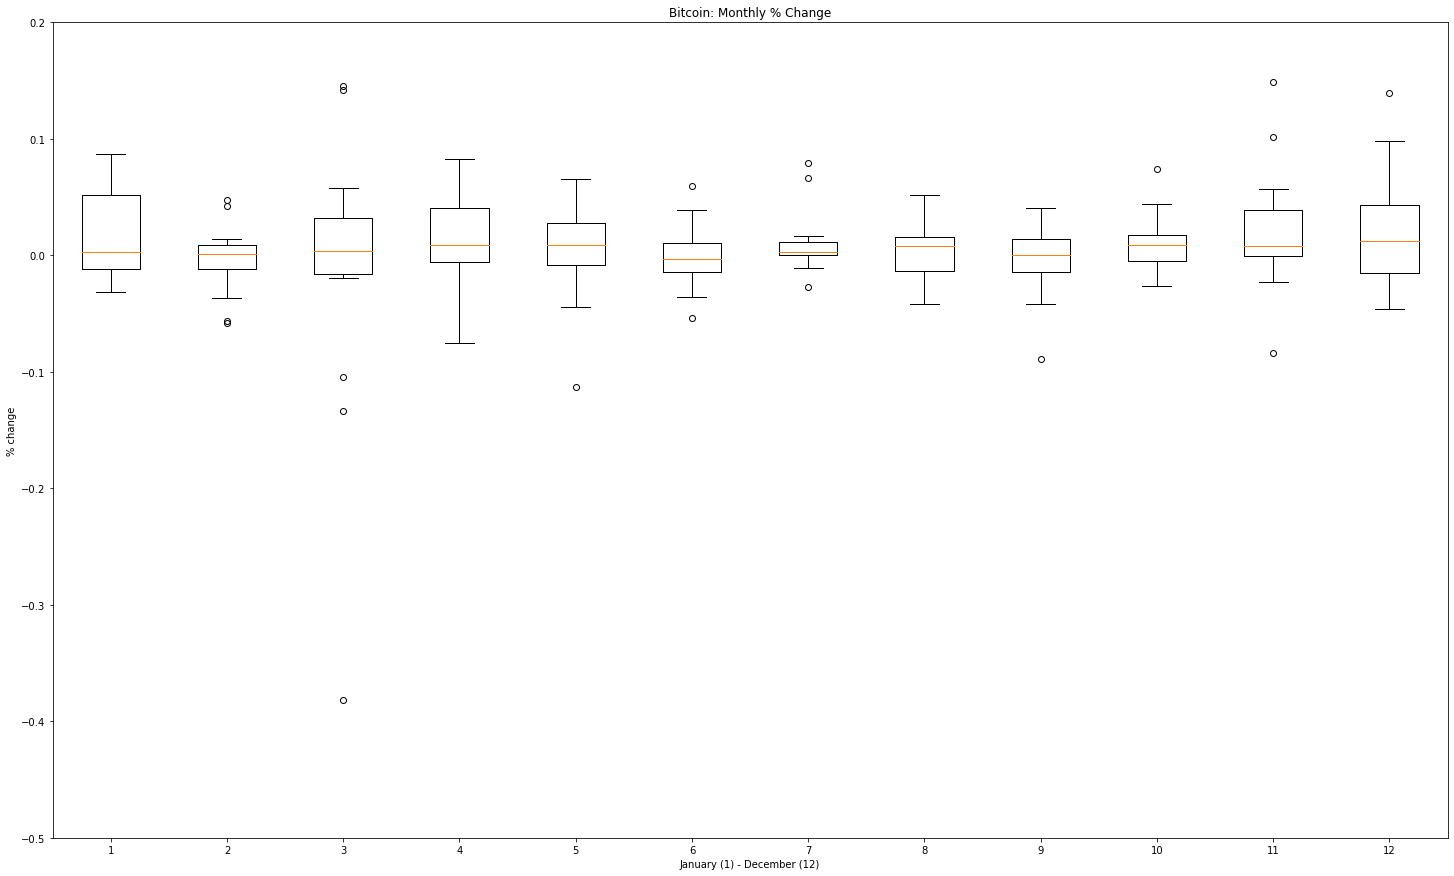

In [522]:
# bitcoin year
months = []

for month in range(1,13):
    item = merged.loc[(merged['month'] == month)]
    months.append(item['% Chg Bitcoin'])


fig1, ax1 = plt.subplots()

ax1.set_title('Bitcoin: Monthly % Change')
ax1.set_ylabel('% change')
ax1.boxplot(months)
plt.xlabel('January (1) - December (12)')
plt.ylim(-0.5,0.2)
fig1.set_size_inches(25, 15, forward=True)
plt.show()

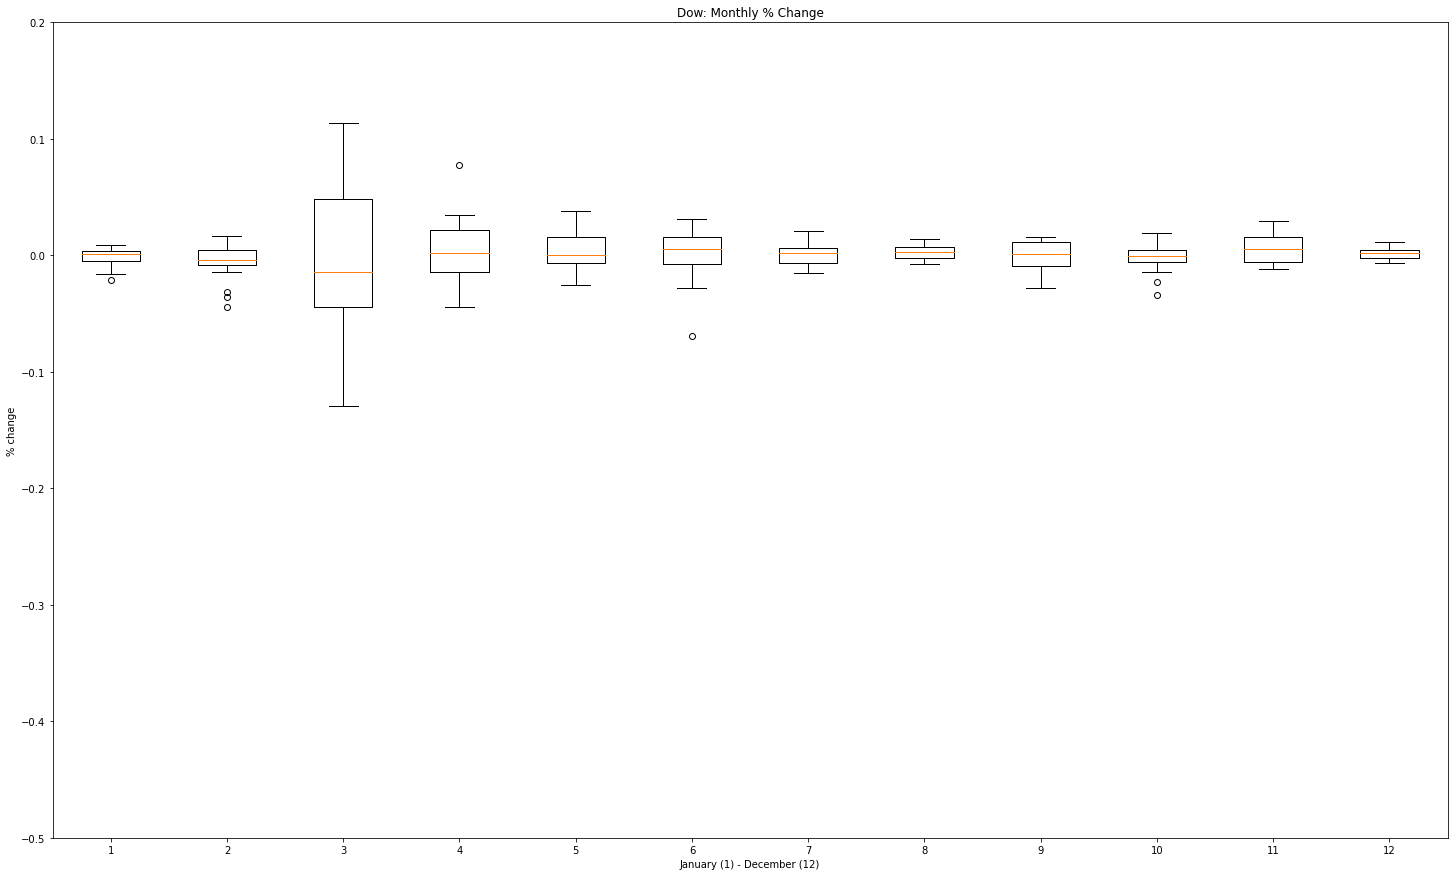

In [520]:
# dow year
months = []

for month in range(1,13):
    item = merged.loc[(merged['month'] == month)]
    months.append(item['% Chg Dow'])


fig1, ax1 = plt.subplots()

ax1.set_title('Dow: Monthly % Change')
ax1.set_ylabel('% change')
ax1.boxplot(months)
plt.xlabel('January (1) - December (12)')
plt.ylim(-0.5,0.2)

fig1.set_size_inches(25, 15, forward=True)
plt.show()

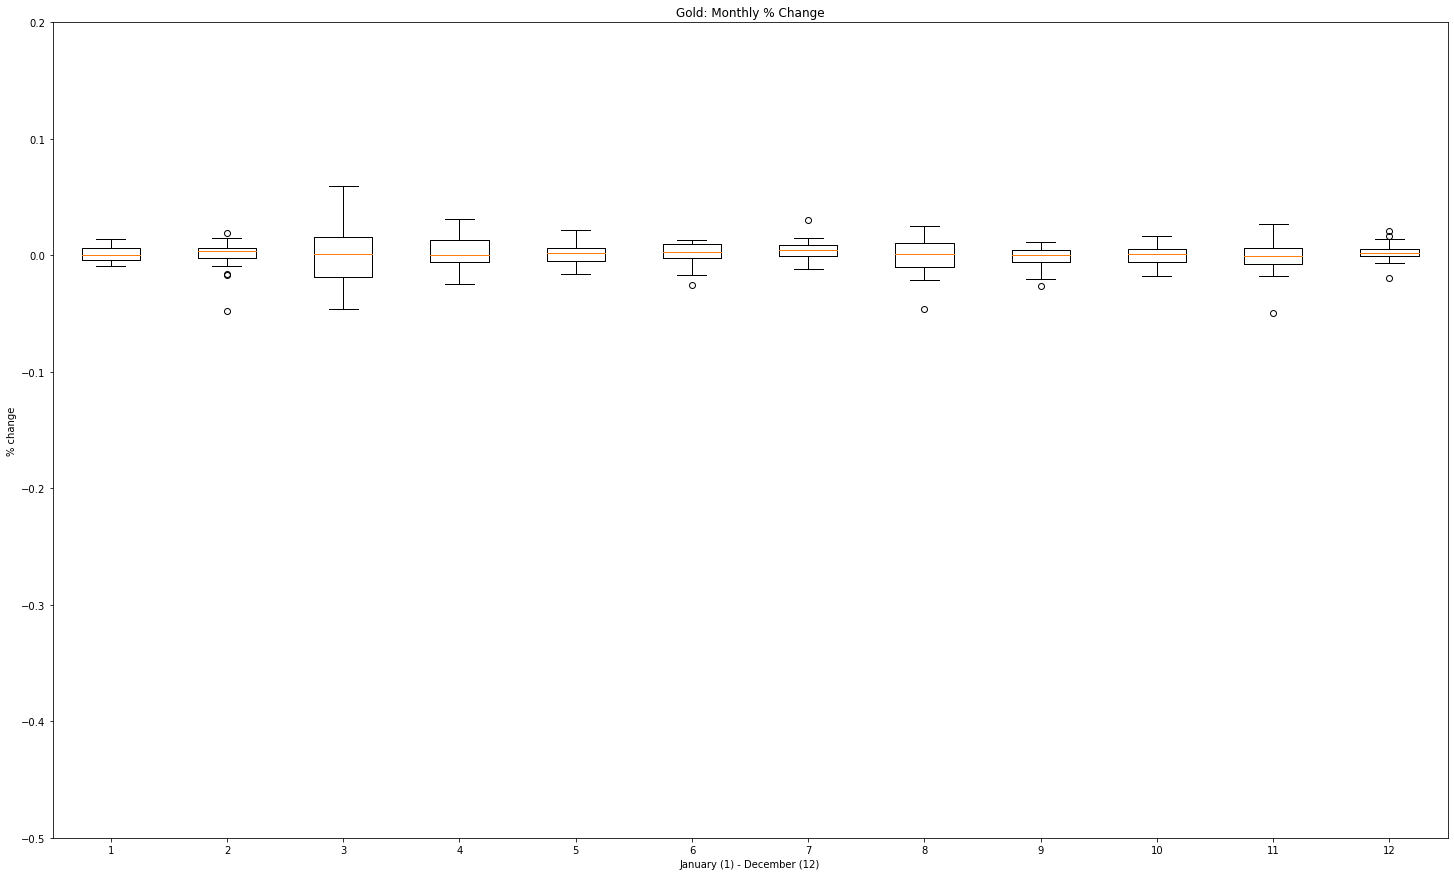

In [486]:
# gold year
months = []

for month in range(1,13):
    item = merged.loc[(merged['month'] == month)]
    months.append(item['% Chg Gold'])


fig1, ax1 = plt.subplots()

ax1.set_title('Gold: Monthly % Change')
ax1.set_ylabel('% change')
ax1.boxplot(months)
plt.xlabel('January (1) - December (12)')
plt.ylim(-0.5,0.2)
fig1.set_size_inches(25, 15, forward=True)
plt.show()

## TO DO:
* Meredith: covid border shut down: february 28-march 26, 2020
* Darren: george floyd/social protests: may 25-june 25, 2020
* Ryan: election: nov 2-nov 9
* Emi: move to Maryland (good luck!)
* Chelsea: year data?


In [81]:
#COVID SECTION: Look between dates 2020-02-28 through 2020-03-26 (Meredith)
start_date = '2020-02-28'
end_date = '2020-03-26'

covid_df = merged.loc[(merged['Date'] >= start_date) & (merged['Date'] <= end_date)]

covid_df

,Date,Bitcoin,Dow,Gold
58,2020-02-28,8715.6617,25409.359375,1564.1
61,2020-03-02,8926.2517,26703.320313,1592.3
62,2020-03-03,8768.1800,25917.410156,1642.1
63,2020-03-04,8767.8867,27090.859375,1643.0
64,2020-03-05,9073.2750,26121.279297,1666.4
65,2020-03-06,9165.1517,25864.779297,1672.4
68,2020-03-09,7944.4500,23851.019531,1675.7
69,2020-03-10,7899.2267,25018.160156,1659.1
70,2020-03-11,7951.1700,23553.220703,1642.3
71,2020-03-12,4914.0850,21200.619141,1590.3


In [82]:
# setting axes to variables
bitcoin_x = covid_df['Bitcoin']
dow_x = covid_df['Dow']
gold_x = covid_df['Gold']
all_y = covid_df['Date']

In [83]:
# set up colors
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

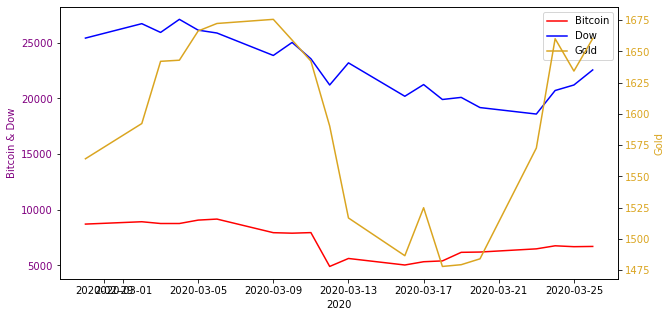

In [84]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()


In [86]:
covid_df.describe()
# for Covid dates

,Bitcoin,Dow,Gold
count,20.000000,20.000000,20.000000
mean,7129.578345,22877.559863,1592.225000
std,1474.355594,2740.331625,73.303212
min,4914.085000,18591.929688,1477.900000
25%,6042.596675,20575.812500,1522.850000
50%,6738.365850,22868.894532,1613.300000
75%,8728.717950,25523.214356,1659.375000
max,9165.151700,27090.859375,1675.700000
